In [228]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [229]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

## Data setup

### Data import

Data loading - the 'clean' data has datetime index 

In [230]:
# df_temp = pd.read_csv(r"C:\Users\macie\OneDrive\Pulpit\Repos\nowcasting\dataset\raw_csv\weather_station_clean.csv", index_col=0)
# df_temp.index = pd.to_datetime(df_temp.index)
# df_temp_resampled = df_temp[(df_temp.temp > -1000)].resample('5T').min()
# df_temp_resampled.fillna(method='ffill', inplace=True)

In [231]:
df_temp = pd.read_csv(r"C:\Users\macie\OneDrive\Pulpit\Fellowship\999_OTHER\DP_paper\Line_Test1.csv")
df_temp.index = df_temp.apply(lambda row: datetime(year=int(row.Year), month=int(row.Month), day=int(row.Day), hour=int(row.Hour), minute=int(row.Minute)), axis=1)
df_temp.rename(columns={'TEMP_LINE_SM1':'temp'}, inplace=True)
df_temp.ffill(inplace=True)
df_temp_resampled = df_temp.copy()

<Axes: >

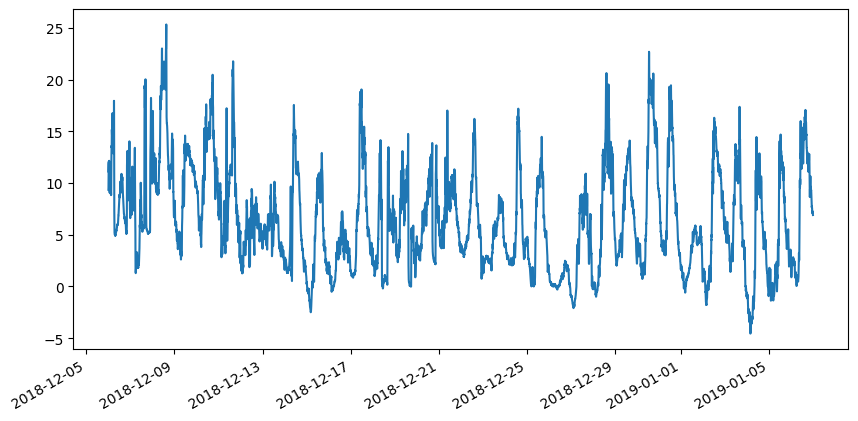

In [232]:
df_temp_resampled.temp.plot(figsize=(10, 5))

Data standardization - std. scaling. We pick only the temperature column

In [233]:
df_data = pd.DataFrame(df_temp_resampled.temp)

data_mean = df_data.mean()
data_std = df_data.std()
df_data = (df_data - data_mean) / data_std

Data splits - train/val/test

In [234]:
len_data = len(df_data)

df_train = df_data[:int(0.7*len_data)]
df_val = df_data[int(0.7*len_data):int(0.9*len_data)]
df_test = df_data[int(0.9*len_data):]

### Time window genrator

Window generator -> to be fed into the model. Sets up the time windows for the model.

In [235]:
class TimeWindowGenerator():

    def __init__(self, input_width, output_width=1, output_offset=1, df_train = df_train, df_val=df_val, df_test=df_test, column_name = ['temp']):

        # define the raw datasets
        self.df_train = df_train
        self.df_val = df_val
        self.df_test = df_test

        # Window parameters
        self.input_width = input_width
        self.output_width = output_width
        self.offset = output_offset
        self.total_size = self.input_width + self.offset
        
        # Define the indices
        self.input_indices = np.arange(0, self.input_width)
        self.output_indices = np.arange(self.total_size - self.output_width, self.total_size)
        
    # model representation when called
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.output_indices}'])
    

    def slice(self, batches):
        # For training probably many batches, for test and deployment: one at a time
        if len(np.shape(batches)) == 3:
            inputs = batches[:, slice(0, self.input_width)]
            output = batches[:, slice(self.total_size - self.output_width, self.total_size)]

        else:
            inputs = batches[slice(0, self.input_width)]
            output = batches[slice(self.total_size - self.output_width, self.total_size)]

        # Set shape for the tf dataset - works only if a tf.Dataset object is fed  
        # e.g., a timeseries_dataset_from_array object
        inputs.set_shape([None, self.input_width, None])
        output.set_shape([None, self.output_width, None])

        return inputs, output
    
    def compile_dataset(self, data, opt_shuffle=True):
        # Convert to numpy float32 - for the keras object
        data_array = np.array(data, dtype='float32')
        
        keras_dataset = tf.keras.utils.timeseries_dataset_from_array(
            data = data_array,
            targets=None,
            sequence_length=self.total_size,
            sequence_stride=1,
            shuffle=opt_shuffle,
            batch_size=32
        )

        keras_dataset = keras_dataset.map(self.slice)

        return keras_dataset
    
    @property
    def train(self):
        return self.compile_dataset(self.df_train)

    @property
    def val(self):
        return self.compile_dataset(self.df_val)

    @property
    def test(self):
        return self.compile_dataset(self.df_test, opt_shuffle=False)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

Universal trainer

In [236]:
def tiny_trainer(model, model_name, window_generator, max_epochs):
  cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=1)
  cb_checkpointing = tf.keras.callbacks.ModelCheckpoint(r'models/line_temp_model_{}_15_mins.hdf5'.format(model_name), monitor='val_loss', save_best_only=True, save_weights_only=True)

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window_generator.train, epochs=max_epochs,
                      validation_data=window_generator.val,
                      callbacks=[cb_early_stopping, cb_checkpointing])
  return history

## Model definitions

### Persistance model - for comparison

In [237]:
window_1 = TimeWindowGenerator(input_width=1, df_train=df_train, df_val=df_val, df_test=df_test, output_offset=3)
window_6 = TimeWindowGenerator(input_width=6, df_train=df_train, df_val=df_val, df_test=df_test, output_offset=3)

In [238]:
window_6

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [8]

### Other models - size restricted

In [239]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

1. MLP model

In [240]:
mlp_model = tf.keras.Sequential([
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layers
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

- 91 Parameters for batch_size = 1

2. Conv model

In [241]:
conv_model = tf.keras.Sequential([
    # Dense layers
    tf.keras.layers.Conv1D(filters = 6, kernel_size=6, strides=2, activation='relu', padding='valid'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1),
])

- 91 Parameters for batch_size = 1

3. LSTM model

In [242]:
lstm_model = tf.keras.Sequential([
    # Dense layers
    tf.keras.layers.LSTM(units=6, return_sequences=False, input_shape=[None, 1]),
    tf.keras.layers.Dense(units=1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])
])

- 148 Parameters for batch_size = 1

4. Conv-LSTM model

In [243]:
lstm_conv_model = tf.keras.Sequential([
    # Dense layer
    tf.keras.layers.Conv1D(filters=6, kernel_size=6, strides=2, activation='relu', padding='valid'),
    tf.keras.layers.LSTM(units=6),
    tf.keras.layers.Dense(1),
    # Reshape into output
    tf.keras.layers.Reshape([-1, 1])

])

- 117 Parameters for batch_size = 1

### Train

In [244]:
persistance_model = Baseline(label_index=None)
history_persitance = tiny_trainer(model=persistance_model, model_name='persistence', window_generator=window_1, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 1s 3ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 2/500
202/202 [==============================] - 0s 1ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 3/500
202/202 [==============================] - 0s 1ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325
Epoch 4/500
202/202 [==============================] - 0s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.1349 - val_loss: 0.0388 - val_mean_absolute_error: 0.1325


In [245]:
history_mlp = tiny_trainer(model=mlp_model, model_name='mlp', window_generator=window_6, max_epochs=500)

Epoch 1/500


202/202 [==============================] - 1s 2ms/step - loss: 0.5517 - mean_absolute_error: 0.4720 - val_loss: 0.8106 - val_mean_absolute_error: 0.5846
Epoch 2/500
202/202 [==============================] - 0s 2ms/step - loss: 0.4106 - mean_absolute_error: 0.3857 - val_loss: 0.6047 - val_mean_absolute_error: 0.5062
Epoch 3/500
202/202 [==============================] - 0s 2ms/step - loss: 0.3092 - mean_absolute_error: 0.3374 - val_loss: 0.4335 - val_mean_absolute_error: 0.4319
Epoch 4/500
202/202 [==============================] - 1s 3ms/step - loss: 0.2252 - mean_absolute_error: 0.2936 - val_loss: 0.2922 - val_mean_absolute_error: 0.3598
Epoch 5/500
202/202 [==============================] - 1s 3ms/step - loss: 0.1634 - mean_absolute_error: 0.2570 - val_loss: 0.1911 - val_mean_absolute_error: 0.2968
Epoch 6/500
202/202 [==============================] - 1s 3ms/step - loss: 0.1247 - mean_absolute_error: 0.2296 - val_loss: 0.1294 - val_mean_absolute_error: 0.2495
Epoch 7/500
202/202 [=

In [246]:
history_conv = tiny_trainer(model=conv_model, model_name='conv1D', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 1s 4ms/step - loss: 1.3863 - mean_absolute_error: 0.9529 - val_loss: 1.1992 - val_mean_absolute_error: 0.9309
Epoch 2/500
202/202 [==============================] - 1s 3ms/step - loss: 0.9569 - mean_absolute_error: 0.7867 - val_loss: 0.8063 - val_mean_absolute_error: 0.7539
Epoch 3/500
202/202 [==============================] - 1s 3ms/step - loss: 0.6517 - mean_absolute_error: 0.6418 - val_loss: 0.5132 - val_mean_absolute_error: 0.5890
Epoch 4/500
202/202 [==============================] - 1s 3ms/step - loss: 0.4331 - mean_absolute_error: 0.5145 - val_loss: 0.3119 - val_mean_absolute_error: 0.4433
Epoch 5/500
202/202 [==============================] - 0s 2ms/step - loss: 0.2835 - mean_absolute_error: 0.4083 - val_loss: 0.1909 - val_mean_absolute_error: 0.3349
Epoch 6/500
202/202 [==============================] - 1s 2ms/step - loss: 0.1915 - mean_absolute_error: 0.3314 - val_loss: 0.1283 - val_mean_absolute_error: 0.2710
Epoch 7/50

In [247]:
history_lstm = tiny_trainer(model=lstm_model, model_name='lstm', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 4s 10ms/step - loss: 0.7015 - mean_absolute_error: 0.6600 - val_loss: 0.9375 - val_mean_absolute_error: 0.7654
Epoch 2/500
202/202 [==============================] - 2s 7ms/step - loss: 0.6047 - mean_absolute_error: 0.6008 - val_loss: 0.8215 - val_mean_absolute_error: 0.6991
Epoch 3/500
202/202 [==============================] - 1s 7ms/step - loss: 0.5150 - mean_absolute_error: 0.5400 - val_loss: 0.7113 - val_mean_absolute_error: 0.6295
Epoch 4/500
202/202 [==============================] - 2s 8ms/step - loss: 0.4333 - mean_absolute_error: 0.4781 - val_loss: 0.6104 - val_mean_absolute_error: 0.5613
Epoch 5/500
202/202 [==============================] - 2s 8ms/step - loss: 0.3641 - mean_absolute_error: 0.4196 - val_loss: 0.5236 - val_mean_absolute_error: 0.4998
Epoch 6/500
202/202 [==============================] - 2s 8ms/step - loss: 0.3102 - mean_absolute_error: 0.3709 - val_loss: 0.4521 - val_mean_absolute_error: 0.4490
Epoch 7/5

In [248]:
history_lstm_conv = tiny_trainer(model=lstm_conv_model, model_name='conv_lstm', window_generator=window_6, max_epochs=500)

Epoch 1/500
202/202 [==============================] - 2s 4ms/step - loss: 0.8769 - mean_absolute_error: 0.7542 - val_loss: 1.1212 - val_mean_absolute_error: 0.8658
Epoch 2/500
202/202 [==============================] - 1s 3ms/step - loss: 0.7696 - mean_absolute_error: 0.7024 - val_loss: 0.9799 - val_mean_absolute_error: 0.8034
Epoch 3/500
202/202 [==============================] - 1s 3ms/step - loss: 0.6669 - mean_absolute_error: 0.6504 - val_loss: 0.8314 - val_mean_absolute_error: 0.7346
Epoch 4/500
202/202 [==============================] - 1s 3ms/step - loss: 0.5530 - mean_absolute_error: 0.5881 - val_loss: 0.6533 - val_mean_absolute_error: 0.6438
Epoch 5/500
202/202 [==============================] - 1s 4ms/step - loss: 0.4270 - mean_absolute_error: 0.5107 - val_loss: 0.4723 - val_mean_absolute_error: 0.5370
Epoch 6/500
202/202 [==============================] - 1s 4ms/step - loss: 0.3098 - mean_absolute_error: 0.4276 - val_loss: 0.3171 - val_mean_absolute_error: 0.4289
Epoch 7/50

### Test

In [249]:
trained_models = {
    'mlp': mlp_model,
    'conv1D': conv_model,
    'lstm': lstm_model,
    'conv_lstm': lstm_conv_model
}

In [250]:
model_error_val = {}
model_error_test = {}

print('Test model: persistence')
model_error_val['persistance'] = persistance_model.evaluate(window_1.val, verbose=1)
model_error_test['persistance'] = persistance_model.evaluate(window_1.test, verbose=1)



for name, model in trained_models.items():
    print(f'Test model: {name}')
    model_error_val[name] = model.evaluate(window_6.val, verbose=1)
    model_error_test[name] = model.evaluate(window_6.test, verbose=1)
    print(f'FS_test = {1- (model_error_test[name][1] / model_error_test["persistance"][1]):.3}, FS_val = {1- (model_error_val[name][1] / model_error_val["persistance"][1]):.3}')

Test model: persistence
29/29 [==============================] - 0s 1ms/step - loss: 0.0465 - mean_absolute_error: 0.1445
Test model: mlp
29/29 [==============================] - 0s 1ms/step - loss: 0.0425 - mean_absolute_error: 0.1418
FS_test = 0.0181, FS_val = 0.0318
Test model: conv1D
29/29 [==============================] - 0s 2ms/step - loss: 0.0519 - mean_absolute_error: 0.1549
FS_test = -0.0726, FS_val = -0.0554
Test model: lstm
29/29 [==============================] - 0s 2ms/step - loss: 0.0527 - mean_absolute_error: 0.1599
FS_test = -0.107, FS_val = -0.058
Test model: conv_lstm
29/29 [==============================] - 0s 2ms/step - loss: 0.0552 - mean_absolute_error: 0.1622
FS_test = -0.123, FS_val = -0.0255


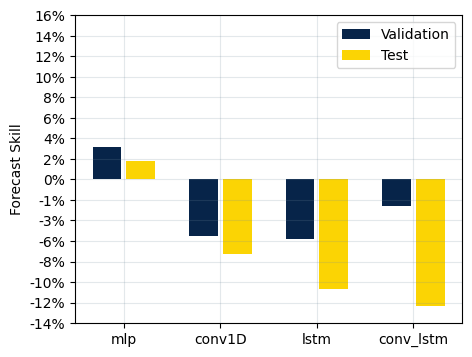

In [251]:

plt.figure(figsize=(5, 4))
x = np.arange(4)
y = np.arange(-0.14, 0.16, 0.02)
width = 0.3

perf_val = [1 - (model_error_val[key][1] / model_error_val['persistance'][1]) for key in list(model_error_val.keys())[1:]]
perf_test = [1 - (model_error_test[key][1] / model_error_test['persistance'][1])for key in list(model_error_val.keys())[1:]]


plt.grid(visible=True, which='major', alpha=0.2, color='#748c9d')

plt.ylabel('Forecast Skill')
plt.bar(x - 0.175, perf_val, width, label='Validation', color='#072449')
plt.bar(x + 0.175, perf_test, width, label='Test', color='#fbd404')
plt.xticks(ticks=x, labels=list(trained_models.keys()))
plt.yticks(ticks=y, labels=[f'{int(item*100)}%' for item in y])
plt.legend()
plt.show()

Potentially with better parameter setup we could achieve better resulst. This is just a 'first test'. However, for now with tiny models we couldn't beat persistance

### Paper

In [252]:
# plt.figure(figsize=(5, 4))
# x = np.arange(4)
# y = np.arange(-0.04, 0.14, 0.02)
# width = 0.3

# models = ['MLP', 'Conv1D', 'LSTM', 'ConvLSTM']
# perf_rmse = [-0.0021, 0.0488, 0.1142, 0.0059]
# perf_mae = [-0.017, 0.0267, 0.0873,-0.043]

# plt.grid(visible=True, which='major', alpha=0.2, color='#748c9d')

# plt.ylabel('Forecast Skill')
# plt.bar(x - 0.175, perf_rmse, width, label='RMSE', color='#072449')
# plt.bar(x + 0.175, perf_mae, width, label='MAE', color='#fbd404')
# plt.xticks(ticks=x, labels=models)
# plt.yticks(ticks=y, labels=[f'{round(item*100)}%' for item in y])
# plt.legend()
# plt.show()

In [253]:
# df_temp = pd.read_csv(r"C:\Users\macie\OneDrive\Pulpit\Fellowship\999_OTHER\DP_paper\Line_Test1.csv")
# df_temp.index = df_temp.apply(lambda row: datetime(year=int(row.Year), month=int(row.Month), day=int(row.Day), hour=int(row.Hour), minute=int(row.Minute)), axis=1)
# df_temp.rename(columns={'TEMP_LINE_SM1':'temp'}, inplace=True)
# df_temp.ffill(inplace=True)
# df_temp_resampled = df_temp.copy()

In [254]:
# sorted = np.sort(df_temp_resampled.temp.values)

# plt.figure(figsize=(6, 4))

# plt.plot(sorted[::-1], label='DLR', color='#2c74e8', linewidth='2')
# plt.axhline(df_temp_resampled.temp.values.min(), label='SLR', color='#b81c36', linewidth='2')
# plt.axhline(0.75, label='130% SLR', color='#424242', linewidth='2', linestyle='--')


# plt.xticks(np.linspace(0, len(sorted), 11), labels=np.arange(0, 110, 10))
# plt.yticks(np.arange(-20, 40, 10), labels=np.arange(0, 600, 100))

# plt.ylabel('Rating [A]')
# plt.xlabel('Percent time [%]')

# plt.grid(visible=True, which='major', alpha=0.2, color='#748c9d')

# plt.text(2000, 3, s='90% of the year', c='r')
# plt.text(1800, -8, s='100% of the year', c='r')

# plt.ylim(-20, 30)
# plt.xlim(0, len(sorted))
# plt.tight_layout()
# plt.legend()
# plt.show()

### Results test

In [255]:
trained_models = {
    'mlp': mlp_model,
    'conv1D': conv_model,
    'lstm': lstm_model,
    'conv_lstm': lstm_conv_model
}

In [256]:
# trained_models = {
#     'mlp': tf.keras.models.load_model('models\line_temp_model_mlp_10_mins.hdf5'),
#     'conv1D': tf.keras.models.load_model('models\line_temp_model_conv1D_10_mins.hdf5'),
#     'LSTM': tf.keras.models.load_model('models\line_temp_model_lstm_10_mins.hdf5'),
#     'conv_lstm': tf.keras.models.load_model('models\line_temp_model_conv_lstm_10_mins.hdf5'),
# }

In [257]:
result = {}

for name, model in trained_models.items():
    model.load_weights(f'models\line_temp_model_{name}_15_mins.hdf5')
    result[name] = model.predict(window_6.test, verbose=1)

 1/29 [>.............................] - ETA: 4s

29/29 [==============================] - 1s 2ms/step


In [258]:
result['pers'] = persistance_model.predict(window_1.test, verbose=1)

29/29 [==============================] - 0s 3ms/step


In [259]:
list_results_mlp = [result['mlp'][i][0][0] for i in range(len(result['mlp']))]
list_results_conv = [result['conv1D'][i][0][0] for i in range(len(result['mlp']))]
list_results_lstm = [result['lstm'][i][0][0] for i in range(len(result['mlp']))]
list_results_conv_lstm = [result['conv_lstm'][i][0][0] for i in range(len(result['mlp']))]
result['pers'] = result['pers'][5:]
list_results_pers = [result['pers'][i][0][0] for i in range(len(result['mlp']))]

In [260]:
values_mlp = (np.array(list_results_mlp)*data_std.values+data_mean.values)
values_conv = (np.array(list_results_conv)*data_std.values+data_mean.values)
values_lstm = (np.array(list_results_lstm)*data_std.values+data_mean.values)
values_conv_lstm = (np.array(list_results_conv_lstm)*data_std.values+data_mean.values)
values_pers = (np.array(list_results_pers)*data_std.values+data_mean.values)
values_true = (df_test.temp.values*data_std.values+data_mean.values)
values_train = (df_train.temp.values*data_std.values+data_mean.values)

In [261]:
y_pred_dict ={
    'MLP': values_mlp,
    #'Conv1D': values_conv,
    #'LSTM': values_lstm,
    #'ConvLSTM': values_conv_lstm,
    'Persistence': values_pers
}

In [262]:
def rolling_mean(data, n):
    return [np.mean(data[i-n:i]) for i in range(n, len(data))]

In [263]:
# from matplotlib.dates import DateFormatter

# fig, ax = plt.subplots(2, figsize=(8, 7), sharex=True, height_ratios=[1, 1.8])

# # for i, key in enumerate(y_pred_dict):
# #     ax[0].plot(df_test.index[6:], y_pred_dict[key], label=f'Prediction {key}', linewidth=1)

# ax[0].plot(df_test.index[6:], values_true[6:], label='True values', color='#072449', linestyle=':')

# ax[0].legend(loc='upper right')
# ax[0].grid(visible=True, which='major', alpha=0.2, color='#748c9d')

# for i, key in enumerate(y_pred_dict):
#     ax[1].semilogy(df_test.index[6:-12], rolling_mean(np.abs(y_pred_dict[key] - values_true[6:]), 12), label=f'{key}', linewidth=1)

# # ax[1].semilogy(df_test.index[6:], np.zeros((len(df_test.index[6:]))), label=f'True values', color='#072449', linestyle=':')


# ax[1].legend(loc='upper right')
# ax[1].grid(visible=True, which='major', alpha=0.2, color='#748c9d')
# ax[0].set_ylabel('Line temperature [C]', fontsize=14)
# ax[1].set_ylabel('Moving average error [log($\Delta$T)]', fontsize=14)
# ax[1].set_xlabel('Hour of the day (5-th of Jan) [hh:mm]', fontsize=14)
# ax[0].set_xlim([datetime(2019, 1, 5, 0), datetime(2019, 1, 6, 0)])


# # Define the date format
# date_form = DateFormatter("%H:%M")
# ax[0].xaxis.set_major_formatter(date_form)

# plt.tight_layout()
# plt.savefig(f'img/DLR/Trend.png', dpi=300)
# plt.show()


In [274]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [264]:
from sklearn import metrics

results_arrays = {
    'Persistance': values_pers,
    'MLP': values_mlp,
    'Conv': values_conv,
    'LSTM': values_lstm,
    'Conv-LSTM': values_conv_lstm,
}

for model, res in results_arrays.items():
    print(f'MAE {model}: {metrics.mean_absolute_error(values_true[8:], res):.3}')
    print(f'RMSE {model}: {np.sqrt(metrics.mean_squared_error(values_true[8:], res)):.3} \n')

MAE Persistance: 0.716
RMSE Persistance: 1.07 

MAE MLP: 0.701
RMSE MLP: 1.02 

MAE Conv: 0.765
RMSE Conv: 1.12 

MAE LSTM: 0.792
RMSE LSTM: 1.13 

MAE Conv-LSTM: 0.802
RMSE Conv-LSTM: 1.16 



*15-min ahead test*

MAE Persistance: 0.716

RMSE Persistance: 1.07 


MAE MLP: 0.746, 0.827, 0.786, 0.838, 0.728

RMSE MLP: 1.07, 1.22, 1.14, 1.24, 1.07   

MAE

| Test | 1 | 2 | 3 | 4 | 5|                       
|---|---|---|---|---|---|
|Persistence| 0.307  | 0.307  | 0.307  | 0.307  | 0.307  |
|MLP|  0.342 |  0.317 | 0.332  | 0.282  | 0.288  |
| CONV| 0.285 | 0.344  | 0.28  | 0.309  |  0.276 |
| LSTM  | 0.276  | 0.283  |  0.279 | 0.275  | 0.288 |
| CONVlstm  | 0.301  | 0.339  | 0.301  | 0.3  | 0.36 |

RMSE

| Test | 1 | 2 | 3 | 4 | 5 |
|---|---|---|---|---|---|
|Persistence| 0.471  | 0.471   | 0.471  | 0.471 | 0.471 |
|MLP| 0.513  | 0.475  | 0.515  | 0.428   | 0.429 |
| CONV| 0.432 | 0.51  |  0.417  | 0.462   |  0.419  |
| LSTM  |  0.412 | 0.419  |  0.416 |  0.414  | 0.425 |
| CONVlstm  | 0.44  | 0.489  | 0.443  | 0.453   | 0.516 |

### Histograms, ICI ect.

In [265]:
# for model, res in results_arrays.items():     
#     plt.figure(figsize=(5, 3))
#     plt.hist((values_true[6:] - res), bins=np.arange(-2.5, 2.5, 0.05), alpha = 0.5, color='#072449')

#     MBE = np.mean(values_true[6:] - res)
#     print(MBE)

#     plt.axvline(metrics.mean_absolute_error(values_true[6:], res), label='MAE', color='#072449')
#     plt.axvline(MBE, label='MBE', color='#fbd404')
#     plt.xlabel("Prediction error [degrees C]")
#     plt.ylabel("Frequency [Samples]")
#     plt.title(f'{model} model')
#     plt.xlim(-2, 2)
#     plt.ylim(0, 100)
#     plt.tight_layout()
#     plt.legend(loc='upper left')
#     plt.grid(visible=True, which='major', alpha=0.2, color='#748c9d')

#     plt.savefig(f'img/DLR/{model}.png', dpi=300)
#     plt.show()

In [266]:
# fig, ax = plt.subplots(5, figsize=(5, 13), sharex=True)
# labels = ['a', 'b', 'c', 'd', 'e']

# for i, (model, res) in enumerate(results_arrays.items()):     
    
#     ax[i].hist((values_true[6:] - res), bins=np.arange(-2.5, 2.5, 0.05), alpha = 0.5, color='#072449')

#     ax[i].axvline(metrics.mean_absolute_error(values_true[6:], res), label='MAE', color='#072449')
#     ax[i].axvline(MBE, label='MBE', color='#fbd404')
#     ax[i].set_xlabel(f"{model} prediction error [°C] \n ({labels[i]})")
#     ax[i].set_ylabel("Frequency [Samples]")
#     # ax[i].title(f'{model} model')
#     ax[i].set_xlim(-2, 2)
#     ax[i].set_ylim(0, 100)
#     ax[i].legend(loc='upper left')
#     ax[i].grid(visible=True, which='major', alpha=0.2, color='#748c9d')

# plt.tight_layout()
# plt.savefig(f'img/DLR/hist_subplots.png', dpi=400)
# plt.show()

In [267]:
# bins = np.arange(-5, 20, 1)
# hist_test, _ = np.histogram(values_true, bins=bins)
# hist_pred, _ = np.histogram(values_mlp, bins=bins)
# hist_pers, _ = np.histogram(values_pers, bins=bins)
# # hist_train, _ = np.histogram(df_train.temp.values*data_std.values+data_mean.values, bins=bins)

In [268]:
# fig, ax = plt.subplots(1, figsize=(6, 4))
# # ax.bar(x=bins[:-1]+0.5, height=np.log10(hist_train + 1), width=0.9, alpha=0.5, label ='Train values', color='#fc0313')
# ax.bar(x=bins[:-1]+0.1, height=hist_test, width=0.9, alpha=0.5, label ='Ground truth', color='#072449')
# ax.bar(x=bins[:-1]+0.1, height=hist_pers, width=0.9, alpha=0.5, label ='Persistance predicion', color='#fc0313')
# ax.bar(x=bins[:-1]+0.1, height=hist_pred, width=0.9, alpha=0.5, label ='MLP prediction', color='#fbd404')

# # plt.hist(values_true[6:], bins=np.arange(-5, 20, 1), alpha=0.5, label='Test values', color='#fbd404')
# # plt.hist(values_mlp, bins=np.arange(-5, 20, 1), alpha=0.5, label='MLP prediction')
# # plt.hist(df_train.temp.values*data_std.values+data_mean.values, )

# ax.set_xlabel('Standardized temperature [-]')
# ax.set_ylim(1, 100)
# ax.set_ylabel('Number of samples [N]')
# ax.grid(visible=True, which='both', alpha=0.2, color='#748c9d')

# ax.legend()

# plt.tight_layout()
# plt.savefig(f'img/DLR/hist_data.png', dpi=400)
# plt.show()

In [269]:
# bins = np.arange(-2, 2.2, 0.2)
# hist_test, _ = np.histogram(values_true[:-1] - values_true[1:], bins=bins)
# hist_pred, _ = np.histogram(values_mlp[:-1] - values_mlp[1:], bins=bins)
# hist_pers, _ = np.histogram(values_pers[:-1] - values_pers[1:], bins=bins)

# hist_train, _ = np.histogram(values_train[:-1] - values_train[1:], bins=bins)

In [270]:
# fig, ax = plt.subplots(1, figsize=(6, 4))
# # ax.bar(x=bins[:-1]+0.5, height=np.log10(hist_train + 1), width=0.9, alpha=0.5, label ='Train values', color='#fc0313')

# ax.plot(bins[:-1]+0.1, hist_test / np.max(hist_test), label ='Training data', color='#072449')
# ax.plot(bins[:-1]+0.1, hist_train / np.max(hist_train), label ='Test data', color='#fbd404')
# ax.plot(bins[:-1]+0.1, hist_pred / np.max(hist_pred), label ='MLP prediction', color='#fc0313')


# # ax.bar(x=bins[:-1]+0.1, height=hist_pers, width=0.2, alpha=0.5, label ='Persistance prediction', color='#fc0313')
# # ax.bar(x=bins[:-1]+0.1, height=hist_pred, width=0.2, alpha=0.5, label ='MLP prediction', color='#fbd404')


# # ax.set_yscale('log')
# # plt.hist(values_true[6:], bins=np.arange(-5, 20, 1), alpha=0.5, label='Test values', color='#fbd404')
# # plt.hist(values_mlp, bins=np.arange(-5, 20, 1), alpha=0.5, label='MLP prediction')
# # plt.hist(df_train.temp.values*data_std.values+data_mean.values, )
# ax.set_xlabel('Temperature variation [°C]')
# ax.set_ylim(0, 1.1)
# ax.set_xlim(-2, 2)
# ax.set_ylabel('Number of samples [N]')
# ax.grid(visible=True, which='both', alpha=0.2, color='#748c9d')

# ax.legend()

# plt.tight_layout()
# plt.savefig(f'img/DLR/intra_hist_data.png', dpi=400)
# plt.show()

In [271]:
# plt.figure(figsize=(6, 4))

# plt.plot(np.cumsum(hist_train)/np.sum(hist_train), label ='Training data', color='#072449')
# plt.plot(np.cumsum(hist_test)/np.sum(hist_test), label ='Test data', color='#fbd404')
# plt.plot(np.cumsum(hist_pred)/np.sum(hist_pred), label ='MLP prediction', color='#fc0313')


# plt.xlabel('Line temperature [°C]')
# plt.ylabel('Cumulative distribution [%]')


# plt.xticks(np.arange(0, 26, 5), labels=np.arange(-5, 21, 5))
# plt.yticks(np.arange(0, 1.2, 0.2), labels=np.arange(0, 101, 20))
# plt.xlim(0, 25)
# plt.ylim(0, 1)
# plt.grid(visible=True, which='both', alpha=0.2, color='#748c9d')
# plt.legend()
# plt.tight_layout()
# plt.savefig(f'img/DLR/cum_hist_data.png', dpi=400)
# plt.show()

In [272]:
# import matplotlib as mpl 

# c_map = mpl.colormaps.get_cmap('winter')


# y_true = values_true[6:]
# step = 100


# plt.figure(figsize=(6, 4))
# for ind, i in enumerate(range(0, 800, step)):

#     h, bins = np.histogram(y_true[0:i+2*step] - values_mlp[0:i+2*step], bins=np.arange(-2, 2.1, 0.1))
#     plt.plot(bins[:-1]+0.1, h / np.max(h), color=c_map(0.1*ind + 0.1), label=f'Start: {i}, End: {i+2*step}')

# plt.xlim(-2, 2)
# plt.ylim(0, 1.2)
# plt.ylabel('Probability distribution [N]')
# plt.xlabel('Temperature resudual [°C]')

# plt.grid(visible=True, which='both', alpha=0.2, color='#748c9d')
# plt.tight_layout()
# plt.legend(loc='upper left')
# plt.savefig(f'img/DLR/moving_hist.png', dpi=400)
# plt.show()

In [273]:
# import matplotlib as mpl 

# c_map = mpl.colormaps.get_cmap('winter')


# y_true = values_true[6:]
# step = 100
# plt.figure(figsize=(6, 4))
# for ind, i in enumerate(range(0, 800, step)):

#     h, bins = np.histogram(y_true[i:i+2*step] - values_mlp[i:i+2*step], bins=np.arange(-2, 2.1, 0.2))

#     plt.plot(bins[:-1]+0.1, np.cumsum(h)/np.sum(h), color=c_map(0.1*ind + 0.1), label=f'Start: {i}, End: {i+2*step}')

# plt.xlim(-1.5, 1.5)
# plt.ylim(0, 1)
# plt.yticks(np.arange(0, 1.1, 0.2), labels=np.arange(0, 101, 20))
# plt.ylabel('Cumulative distribution [%]')
# plt.xlabel('Temperature resudual [°C]')

# plt.grid(visible=True, which='both', alpha=0.2, color='#748c9d')
# plt.tight_layout()
# plt.legend()
# plt.savefig(f'img/DLR/moving_cum.png', dpi=400)
# plt.show()
